<a href="https://colab.research.google.com/gist/AlexandraSharapova/5f5bdf3f120667116783e8ed98dbb096/mlflow-guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Working with the project and running the experiment
A project is a folder with files associated with this project:

* MLProject metadata file (YAML format) and also included files (e.g. conda.yaml)
* Files with code for running experiments (for example, in Python)
* To create a project, it is sufficient to describe a valid MLProject file.

In [ ]:
!pip install mlflow #for running in jupyter notebook

### Open command line and run 
#### `pip  install mlflow`
 
### As soon as installation completes successfully

### run `mlflow ui`  to get access to the environment

### Project creation example

The `MLproject` project file specifies that the model is trained in the `conda` environment and uses `scikit-learn` as the ML library (specified in `conda.yaml`). The training of the model itself is described in the `train.py` file, the necessary data preparation is also described there.

In [ ]:
%%writefile MLproject
name: mlflow_guide

conda_env: conda.yaml

entry_points:
  main:
    parameters:
      alpha: float
      l1_ratio: {type: float, default: 0.1}
    command: "python train.py {alpha} {l1_ratio}"

Overwriting MLproject


In [ ]:
%%writefile conda.yaml
name: mlflow_guide
channels:
  - defaults
dependencies:
  - numpy>=1.14.3
  - pandas>=1.0.0
  - scikit-learn=0.19.1
  - pip
  - pip:
    - mlflow

Overwriting conda.yaml


For the next steps we use  [Wine Quality](https://github.com/mlflow/mlflow-example) dataset


In [ ]:
!pip install sklearn

In [ ]:
from sklearn.datasets import load_wine #dataset import

#### Preparing data for experiment

The following code imports the modules necessary for work, loads the data from the `wine-quality.csv` file and separates them into test and validation samples


In [ ]:
import os
import sys
import warnings
from pprint import pprint

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

import mlflow
import mlflow.sklearn

MLFLOW_SERVER_URL = 'http://127.0.0.1:5000/'

warnings.filterwarnings("ignore")
np.random.seed(40)

df = load_wine()
data = pd.DataFrame(df=df.df, columns=df.feature_names)

train, test = train_test_split(data)

train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.2 KB


In [ ]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2213,7.4,0.17,0.29,1.4,0.047,23.0,107.0,0.99390,3.52,0.65,10.4,6
3375,7.8,0.22,0.26,9.0,0.047,38.0,132.0,0.99700,3.25,0.53,10.2,6
4596,6.7,0.53,0.29,4.3,0.069,20.0,114.0,0.99014,3.22,0.59,13.4,6
4360,7.3,0.28,0.35,1.6,0.054,31.0,148.0,0.99178,3.18,0.47,10.7,5
269,5.4,0.59,0.07,7.0,0.045,36.0,147.0,0.99440,3.34,0.57,9.7,6


### Create and run an experiment
The code of the experiment itself does not depend on MLflow, you can use ready-made code.


To fix the run parameters and model metrics, you need to run training within the experiment and project.

`tracking_url` - URL of the raised mlflow server that will be used to store experiments. A web interface is also available at this address for viewing the results of launches.

In [ ]:
# connecting with server
mlflow.set_tracking_uri(MLFLOW_SERVER_URL)

experiment_name = 'MLFlow_guide_exp2'
mlflow.set_experiment(experiment_name)

# launching experiment
with mlflow.start_run():
    alpha = 0.5
    l1_ratio = 0.5

    # model
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    # metrics
    predicted_qualities = lr.predict(test_x)
    rmse = np.sqrt(mean_squared_error(test_y, predicted_qualities))
    mae = mean_absolute_error(test_y, predicted_qualities)
    r2 = r2_score(test_y, predicted_qualities)

    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    # saving experiment results in the server
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    mlflow.sklearn.log_model(lr, "model")

2022/01/31 01:51:01 INFO mlflow.tracking.fluent: Experiment with name 'MLFlow_guide_exp2' does not exist. Creating a new experiment.


Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 0.8222428497595401
  MAE: 0.6278761410160693
  R2: 0.12678721972772666


Then go to MLFLOW_SERVER_URL = 'http://127.0.0.1:5000/'

The environment will look like that

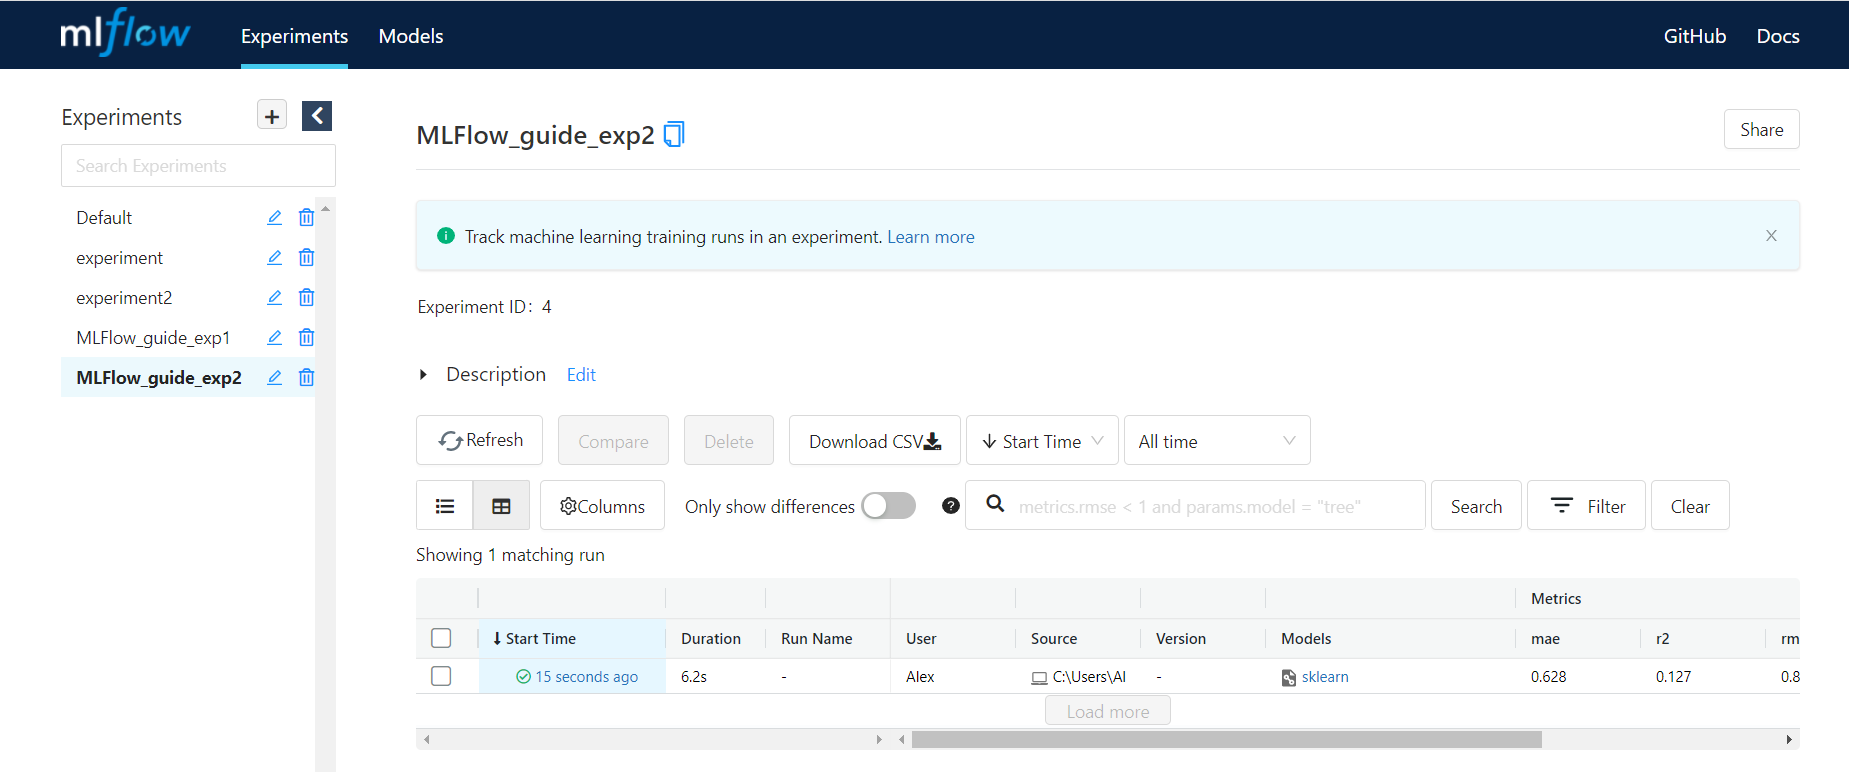
